# **Exercise 1**
The graph atsp18062019.gml represents a logistic distribution network.
Each arc has a cost [dist attribute in the graph].
The company must deliver one unit of good to each node of the graph.
Calculate the costs of the following delivering strategies:

- 1.The company stores all goods in node 1and uses a vehicle with C = 50.
- 2.The company uses a vehicle with C = 50 but goods are not stored in node 1.Precisely, the company maylocate a warehouse in one of the following nodes: {2,15,20}.
- 3.The company decides to store goods inall three locations and to use 3 vehicles that travel up to 10 nodes each.

If one of the problems above can be formulated as an ATSP, then use the lifted MTZ formulation plus the size 2 subtour inequalities. 

For this model, report the value  of  the  linear  relaxation  and  the  number  of  enumerated  nodes.Then, strengthen the formulation by adding violated Subtour Elimination Constraintsand  calculatethe  improved  linear  relaxation  and  the  number  of  enumerated nodes of the strengthened model.

In [12]:
import gurobipy as gb
import networkx as nx
import matplotlib.pyplot as plt
import os


#
# Drawing 
# functions
#


def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
        

    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        


        
        
    
    plt.axis('off')
    plt.show()


def DrawSubtour (G, x, subtour):

    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}


    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o',
                           nodelist=subtour,
                           node_size=600,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    

    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
    
    for u,v in subtouredges:
        if x[u,v].x > 0.01 and x[u,v].x < 0.99:

            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],
                                   edge_color='r')

            nx.draw_networkx_edge_labels(G, pos=pos, 
                                         edge_labels={(u,v):f'[{x[u,v].x:.2f}, {x[v,u].x:.2f}]'})

            
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],\
                                   edge_color='k')
            
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    scale = 15
    figsize = (10,10)

## mTSP

>**Given**
>A directed graph $G=(N,A)\;$ and a cost $c_{ij} > 0$ for each arc in $A$
>
>**Find**
> A set of routes for $m$ salesmen who all start from and turn back to a home city (depot, node 1) 
 


### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} c_{ij} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
\sum_{(i,j) \in A(S)} x_{ij} &\le |S| - 1 \;\; \forall S \subset N \setminus \{1\}, |S| \ge 2 \;\; \text{(SEC)}\\
\text {or}\\
\sum_{(i,j) \in \delta^+(S)} x_{ij} &\ge 1 \;\; \forall S \subset N, \{1\} \in S\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [8]:
# Read the graph in the graphML format

args.filename = 'atsp18062019.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

args.figsize = (20,20)

#print(G.edges(data=True))
#print(G.nodes(data=True))

G has 28 nodes and 756 edges
True


In [9]:
root = list(G.nodes())[0]

## **Ex2_Q3 ->** 3.The company decides to store goods inall three locations and to use 3 vehicles that travel up to 10 nodes each.

## mTSP MTZ constraints

### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} c_{ij} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
u_i - u_j + p x_{ij} &\le p-1 \;\; \forall (i,j) \in A, i,j \not = 1\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [10]:
m = 3
p = 10
wharehouses = [2, 15, 20]

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1109 rows, 784 columns and 4320 nonzeros
Model fingerprint: 0xca679d4d
Variable types: 28 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Presolve removed 205 rows and 109 columns
Presolve time: 0.01s
Presolved: 904 rows, 675 columns, 3606 nonzeros
Variable types: 24 continuous, 651 integer (651 binary)
Found heuristic solution: objective 50980.000000

Root relaxation: objective 1.698750e+04, 108 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 16987.5000    0   26 50980.0000 16987.5000  66.7%     -    0s
H    0     0                    43151.0000

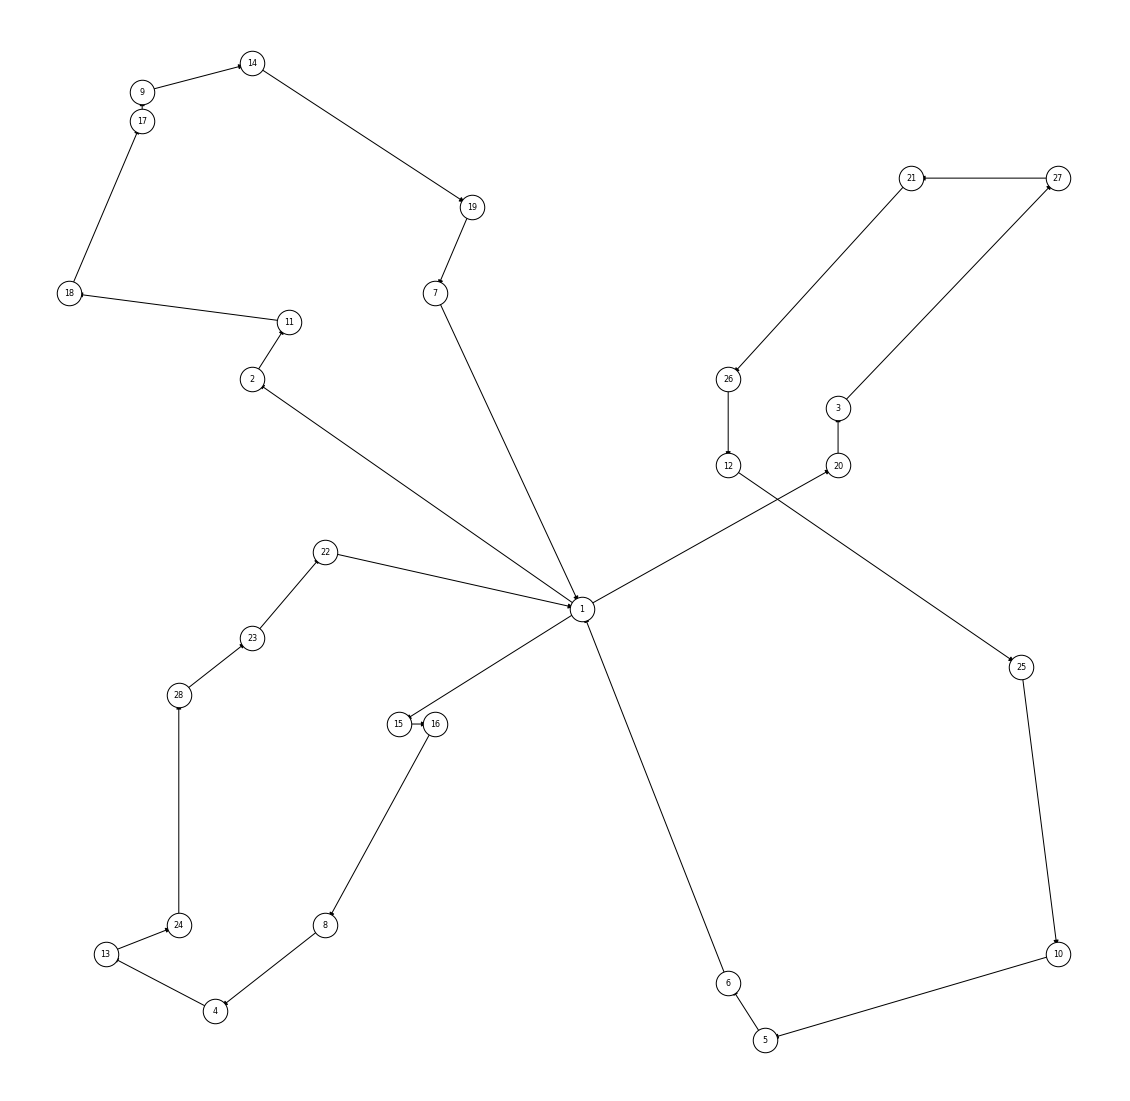

In [11]:
mtsp_mtz = gb.Model()

## Variables
x2 = mtsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u2 = mtsp_mtz.addVars(G.nodes(), obj=0.0, vtype=gb.GRB.CONTINUOUS,\
                     lb=1.0, ub=p, name='u')

## Constraints  
mtsp_mtz.addConstr(x2.sum(root,'*') == m, name = 'OUT-R')
mtsp_mtz.addConstr(x2.sum('*',root) == m, name = 'IN-R')

mtsp_mtz.addConstrs((x2.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp_mtz.addConstrs((x2.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp_mtz.addConstrs((x2[i,j] + x2[j,i] <= 1 \
                 for i,j in G.edges() if j > i \
                     and i != root and j != root ), name='SUB2')

u2[root].lb = 0
u2[root].ub = 0

# we impose that the fisrt 3 node visited are the wharehouses
for curr_wharehouse in wharehouses:
    x2[root, curr_wharehouse].lb = 1
    x2[root, curr_wharehouse].ub = 1

mtsp_mtz.addConstrs((u2[i] - u2[j] + p * x2[i,j] <= p - 1 \
                     for i in G.nodes() for j in G.nodes()\
                    if i != j and i != root and j != root and G.has_edge(i,j)), name='MTZ')

mtsp_mtz._graph = G
mtsp_mtz._vars = x2

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

mtsp_mtz.optimize()

print("\n------------------------------------------------------------------------------\n")
print ("-> Solution", mtsp_mtz.objVal)
print("\n------------------------------------------------------------------------------\n")

DrawSol(G, x2)